#### Programa de Formación en ML & DS
## Introducción al Aprendizaje Automático
# Sesión 3: Clasificación no lineal, complejidad y sobreajuste (Taller)

Definimos primero unas librerías y funciones que vamos a usar a durante la sesión:

In [1]:
# https://pypi.python.org/pypi/pydot-
!pip install graphviz

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import pandas as pd
from sklearn import preprocessing
from sklearn import datasets
import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
import pydot

# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")
    
# Función para visualizar de la superficie de decisión de un clasificador
def plot_decision_region(X, pred_fun):
    print(X.shape)
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 100, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")
    
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

# Taller

Siguiendo con el uso del conjunto de datos **Wine** visto durante la clase de hoy se procede a realizar lo siguiente:

1. Cargue el conjunto de datos **Wine**.
2. Genere una partición estratificada 70-30 sobre el conjunto de datos.
3. Genere una gráfica de barras en Pandas que verifique que las particiones de entrenamiento y prueba tengan la misma distribución de clases.

## Explorando la complejidad usando `KNearestNeighbor`
4. Entrene un modelo `KNearestNeighbor`. Use los siguientes valores para evaluar la complejidad:
    * $[1, 2, 3, \dots, 20]$
    * Grafique los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.
5. Construya un conjunto de datos usando las características `Proline` contra `Flavonoids`. 
    * Use la partición 70-30 definida al inicio
    * Usando `KNearestNeighbor`, determine el número subóptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$: $[1, 2, 3, \dots, 20]$
    * Grafique la superficie de decisión contra los ejemplos de test.
    * Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

## Explorando la complejidad usando `DecisionTree`
6. Entrene un modelo de árbol de decisión usando los siguientes valores de profundidad:
    * $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
    * Grafique los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.
7. Construya un conjunto de datos usando las características `Alcalinity` contra `Malic Acid`.
    * Use la partición 70-30 definida al inicio
    * Usando `DecisionTree`, determine el número subóptimo de profundidad máxima usando evaluación de la complejidad. Use los mismos valores de $\textit{max_depth}$: $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
    * Grafique la superficie de decisión contra los ejemplos de test.
    * Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

## Visualización usando `DecisionTree`
8. Escoja el mejor modelo entrenado sobre las 13 características. Visualice el árbol de decisión.
9. ¿Cuales son las características más importantes del modelo?
10. Exprese 5 reglas de decisión con base al árbol entrenado.


###1. Cargamos el conjunto de datos **Wine** como un DataFrame de pandas.

In [5]:
wine = pd.read_csv("wine.data.txt")
wine.head(5)

,Class,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [8]:
wine_no_class = wine.drop(columns="Class")
wine_no_class.head(5)

,Alcohol,Malic_acid,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoid,Proanthocyanins,Color,Hue,OD280/OD315,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [16]:
X = wine_no_class.as_matrix()
y = wine["Class"].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


###2. Generamos una partición estratificada 70-30 sobre el conjunto de datos cargados.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

###3. Generamos una gráfica de barras en Pandas que verifique que las particiones de entrenamiento y probamos tengan la misma distribución de clases.

Text(0, 0.5, 'Freq')

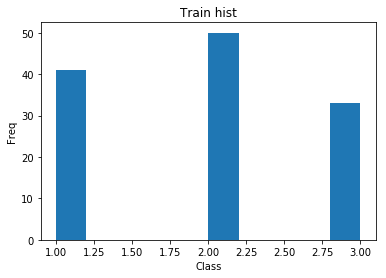

In [18]:
plt.hist(y_train)
plt.title("Train hist")
plt.xlabel("Class")
plt.ylabel("Freq")

Text(0, 0.5, 'Freq')

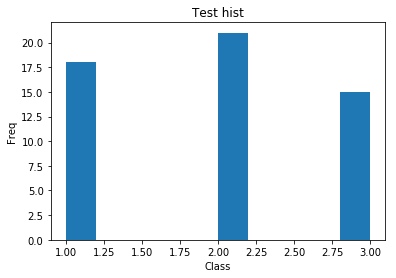

In [19]:
plt.hist(y_test)
plt.title("Test hist")
plt.xlabel("Class")
plt.ylabel("Freq")

## Explorando la complejidad usando `KNearestNeighbor`

###4. Entrenamos un modelo `KNearestNeighbor`. Usamos los siguientes valores para evaluar la complejidad:###
   * $[1, 2, 3, \dots, 20]$
   * Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [0]:
error_train = []
error_test = []
for i in range(1,21):
  knn =  KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  error_train.append(1-knn.score(X_train, y_train))
  error_test.append(1-knn.score(X_test, y_test))

In [0]:
error_tr_np = np.array(error_train)
error_te_np = np.array(error_test)
parameter = np.arange(1, 21)

Text(0, 0.5, 'Error')

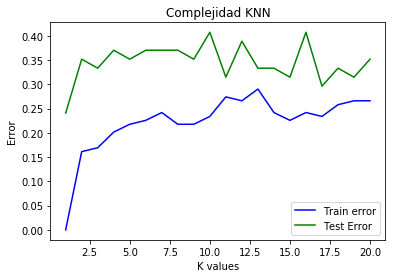

In [23]:
plt.plot(parameter, error_tr_np, "b-", label="Train error")
plt.plot(parameter, error_te_np, "g-", label="Test Error")
plt.legend()
plt.title("Complejidad KNN")
plt.xlabel("K values")
plt.ylabel("Error")

###5. Construimos un conjunto de datos usando las características `Proline` contra `Flavonoids`. 
   * Usamos la partición 70-30 definida al inicio
   * Usando `KNearestNeighbor`, determinamos el número subóptimo de k-vecinos usando evaluación de la complejidad. Use los mismos valores de $k$: $[1, 2, 3, \dots, 20]$
   * Graficamos la superficie de decisión contra los ejemplos de test.
   * Reportamos accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

In [24]:
wine.columns

Index(['Class', 'Alcohol', ' Malic_acid', ' Ash', ' Alcalinity', ' Magnesium',
       ' Phenols', ' Flavanoids', ' Nonflavanoid', ' Proanthocyanins', 'Color',
       ' Hue', ' OD280/OD315', ' Proline    '],
      dtype='object')

In [25]:
X_2 = wine[[" Proline    ", " Flavanoids"]].as_matrix()
print(X_2.shape)

(178, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.30, stratify=y, 
                                                    random_state=132)

In [0]:
error_train = []
error_test = []
for i in range(1,21):
  knn =  KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train)
  error_train.append(1-knn.score(X_train, y_train))
  error_test.append(1-knn.score(X_test, y_test))

In [28]:
err_test = np.array(error_test)
min_err = err_test.min()
print(min_err)
print("index: {}".format(min_err.argmin()))

0.2407407407407407
index: 0


In [29]:
err_test

array([0.24074074, 0.31481481, 0.35185185, 0.35185185, 0.31481481,
       0.33333333, 0.35185185, 0.38888889, 0.35185185, 0.31481481,
       0.31481481, 0.37037037, 0.31481481, 0.33333333, 0.27777778,
       0.2962963 , 0.31481481, 0.2962963 , 0.31481481, 0.31481481])

In [30]:
knn_optimo = KNeighborsClassifier(n_neighbors=5) 
knn_optimo.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

(54, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


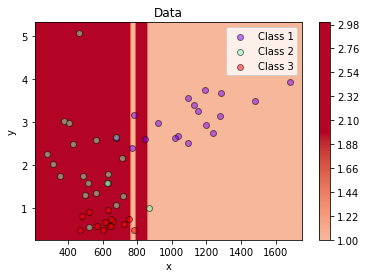

In [31]:
plot_decision_region(X_test, gen_pred_fun(knn_optimo))
plot_data(X_test, y_test)

In [32]:
from sklearn import metrics
y_pred = knn.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.6851851851851852


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precisión macro: {}'.format(precision_score(y_test, y_pred, average='macro')))
print('Precisión micro: {}'.format(precision_score(y_test, y_pred, average='micro')))
print('Precisión pesada: {}'.format(precision_score(y_test, y_pred, average='weighted')))


print('Recall macro: {}'.format(recall_score(y_test, y_pred, average='macro')))
print('Recall micro: {}'.format(recall_score(y_test, y_pred, average='micro')))
print('Recall pesada: {}'.format(recall_score(y_test, y_pred, average='weighted')))

print('F1 macro: {}'.format(f1_score(y_test, y_pred, average='macro')))
print('F1 micro: {}'.format(f1_score(y_test, y_pred, average='micro')))
print('F1 pesada: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Precisión macro: 0.7289102564102564
Precisión micro: 0.6851851851851852
Precisión pesada: 0.7449786324786324
Recall macro: 0.7031746031746032
Recall micro: 0.6851851851851852
Recall pesada: 0.6851851851851852
F1 macro: 0.6901960784313724
F1 micro: 0.6851851851851852
F1 pesada: 0.6895424836601307


## Explorando la complejidad usando `DecisionTree`

6. Entrenamos un modelo de árbol de decisión usando los siguientes valores de profundidad:
    * $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
    * Graficamos los errores de entrenamiento y generalización conforme a la complejidad el modelo aumenta.

In [0]:
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
classifier = DecisionTreeClassifier()


train_error = []
generalization_error = []
max_depth_values = list(range(1, 11, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_train, y_train)
    train_error.append(1 - decision_tree.score(X_train, y_train))
    generalization_error.append(1 - decision_tree.score(X_test, y_test))

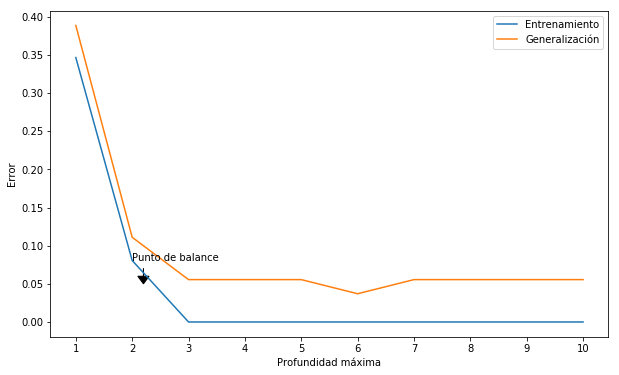

In [35]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(2.2, 0.07, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.08, 'Punto de balance')
pl.legend();

7. Construyamos un conjunto de datos usando las características `Alcalinity` contra `Malic Acid`.
    * Usamos la partición 70-30 definida al inicio
    * Usando `DecisionTree`, determine el número subóptimo de profundidad máxima usando evaluación de la complejidad. Use los mismos valores de $\textit{max_depth}$: $[1, 2, 3, 4, 5, 7, 8, 9, 10]$
    * Grafique la superficie de decisión contra los ejemplos de test.
    * Reporte accuracy, el error de clasificación, la precisión macro, el recall macro y el F1 score macro sobre el **conjunto de prueba**.

In [36]:
X_2 = wine[[" Alcalinity", ' Malic_acid']].as_matrix()
print(X_2.shape)

(178, 2)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_2, y, test_size=0.30, stratify=y, random_state=132)

In [0]:
train_error = []
generalization_error = []
max_depth_values = list(range(1, 11, 1))

for depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=depth)
    decision_tree.fit(X_trainR, y_trainR)
    train_error.append(1 - decision_tree.score(X_trainR, y_trainR))
    generalization_error.append(1 - decision_tree.score(X_testR, y_testR))

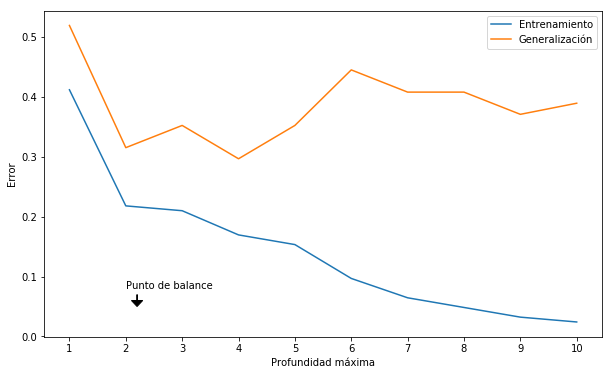

In [40]:
pl.figure(figsize = (10, 6))

pl.plot(max_depth_values, train_error, label="Entrenamiento")
pl.plot(max_depth_values, generalization_error, label="Generalización")
pl.xticks(max_depth_values)
pl.xlabel("Profundidad máxima")
pl.ylabel("Error")
pl.arrow(2.2, 0.07, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
pl.text(2, 0.08, 'Punto de balance')
pl.legend();

(124, 2)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


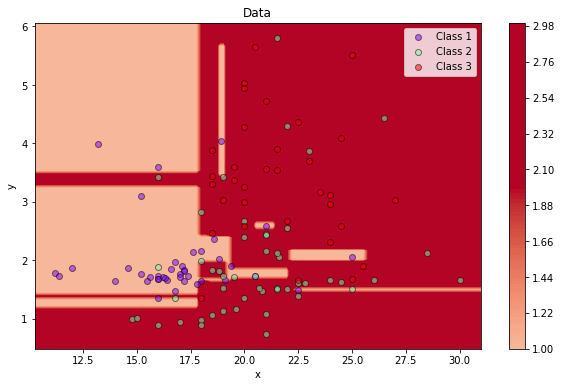

In [41]:
classifier = classifier.fit(X_trainR, y_trainR)
pl.figure(figsize = (10, 6))    
plot_decision_region(X_trainR, gen_pred_fun(classifier))
plot_data(X_trainR, y_trainR)

## Visualización usando `DecisionTree`

8. Escoja el mejor modelo entrenado sobre las 13 características. Visualice el árbol de decisión.

In [0]:
#El mejor modelo según la gráfica mostrada es cuando se utiliza una profundidad de 6.
decision_tree = DecisionTreeClassifier(max_depth=6)
decision_tree.fit(X_train, y_train)
train_error.append(1 - decision_tree.score(X_train, y_train))
generalization_error.append(1 - decision_tree.score(X_test, y_test))
classifier = classifier.fit(X_test, y_test)


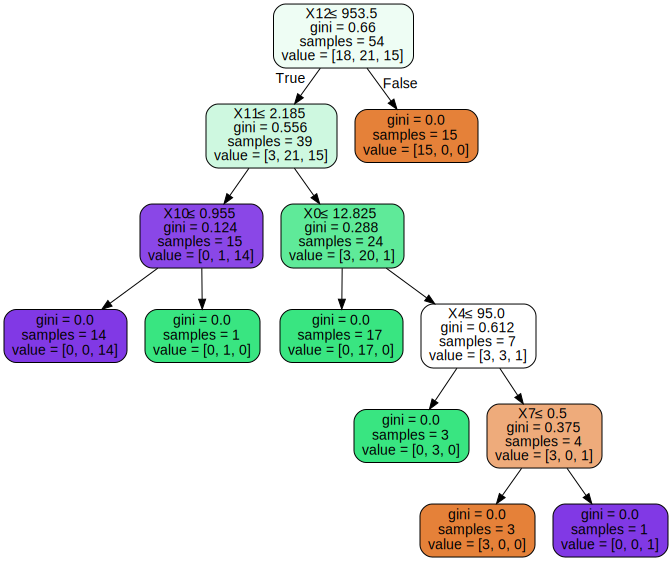

In [43]:
from IPython.display import SVG
dot_data = export_graphviz(classifier, out_file=None,          
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)
SVG(graph.pipe(format='svg'))

9. ¿Cuales son las características más importantes del modelo?

In [44]:
classifier.feature_importances_

array([0.07376502, 0.        , 0.        , 0.        , 0.07810414,
       0.        , 0.        , 0.04205607, 0.        , 0.        ,
       0.05233645, 0.36193386, 0.39180446])

**Respuesta: Las caracteristicas más importantes son las indexadas con los indices 0, 8,11 y 12. Es decir, 'Alcohol',  ' Proanthocyanins', ' OD280/OD315', ' Proline    '**

10. Exprese 5 reglas de decisión con base al árbol entrenado.


1. Si proline es menor a 953.5 revise ' OD280/OD315.
2. Si proline no es menor a 953.5 entonces clasificación "Clase 1".
3. Si ' OD280/OD315 es  menor  2.1285 revise Proanthocyanins' de lo contrario revise 'Alcohol
4. Si Proanthocyanins' es menor o igual a 0.485 clasifique en "Clase 2".
5. Si Alconhol es menor a 12.825 clasifique en "Clase 2".